## Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

batch_size = 512
num_classes = 10
img_rows, img_cols = 28, 28

Using TensorFlow backend.


## Load data

In [2]:
X_train, y_train, X_train_skel_features = None, None, None
with open("data/train_info", "rb") as fin:
    data = pickle.load(fin)
    X_train, y_train, X_train_skel_features = data["data"], data["labels"], data["skel_features"]

X_test, y_test, X_test_skel_features = None, None, None
with open("data/test_info", "rb") as fin:
    data = pickle.load(fin)
    X_test, y_test, X_test_skel_features = data["data"], data["labels"], data["skel_features"]    

## Create data for network

In [3]:
x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Create f1 score

In [4]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Generate model

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy', f1])

## Create callbacks

In [6]:
early_stopping = EarlyStopping(monitor='val_acc', mode='max', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.5, patience=3, verbose=1)
callbacks=[early_stopping, model_checkpoint, reduce_lr]

## Fit model

In [7]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10000,
          callbacks=callbacks,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10000
60000/60000 [==============================] - 11s 177us/step - loss: 1.5576 - acc: 0.4479 - f1: 0.3547 - val_loss: 0.4042 - val_acc: 0.8751 - val_f1: 0.8590

Epoch 00001: val_acc improved from -inf to 0.87510, saving model to best_model.h5
Epoch 2/10000
60000/60000 [==============================] - 3s 44us/step - loss: 0.6752 - acc: 0.7822 - f1: 0.7760 - val_loss: 0.2249 - val_acc: 0.9335 - val_f1: 0.9340

Epoch 00002: val_acc improved from 0.87510 to 0.93350, saving model to best_model.h5
Epoch 3/10000
60000/60000 [==============================] - 3s 45us/step - loss: 0.5032 - acc: 0.8405 - f1: 0.8400 - val_loss: 0.1732 - val_acc: 0.9510 - val_f1: 0.9514

Epoch 00003: val_acc improved from 0.93350 to 0.95100, saving model to best_model.h5
Epoch 4/10000
60000/60000 [==============================] - 3s 45us/step - loss: 0.4213 - acc: 0.8657 - f1: 0.8671 - val_loss: 0.1441 - val_acc: 0.9572 - val_f1: 0.9573

Epoch 00004:

60000/60000 [==============================] - 3s 44us/step - loss: 0.1720 - acc: 0.9489 - f1: 0.9497 - val_loss: 0.0580 - val_acc: 0.9823 - val_f1: 0.9819

Epoch 00034: val_acc did not improve from 0.98410
Epoch 35/10000
60000/60000 [==============================] - 3s 44us/step - loss: 0.1689 - acc: 0.9492 - f1: 0.9503 - val_loss: 0.0547 - val_acc: 0.9827 - val_f1: 0.9828

Epoch 00035: val_acc did not improve from 0.98410
Epoch 36/10000
60000/60000 [==============================] - 3s 44us/step - loss: 0.1694 - acc: 0.9495 - f1: 0.9506 - val_loss: 0.0531 - val_acc: 0.9833 - val_f1: 0.9837

Epoch 00036: val_acc did not improve from 0.98410

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.25.
Epoch 37/10000
60000/60000 [==============================] - 3s 45us/step - loss: 0.1669 - acc: 0.9502 - f1: 0.9513 - val_loss: 0.0535 - val_acc: 0.9834 - val_f1: 0.9836

Epoch 00037: val_acc did not improve from 0.98410
Epoch 38/10000
60000/60000 [==============================] - 3

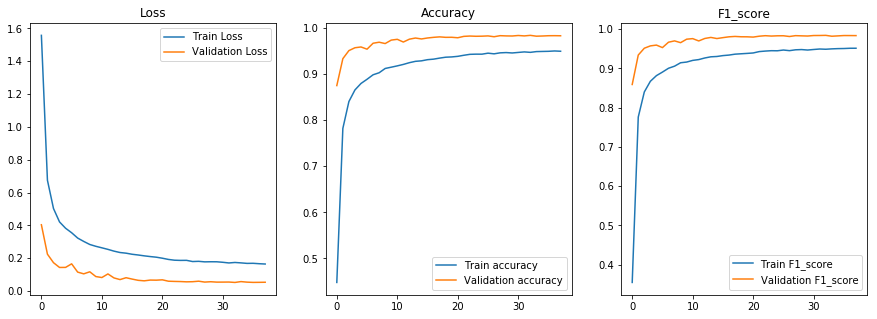

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["acc"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax[2].set_title('F1_score')
ax[2].plot(history.epoch, history.history["f1"], label="Train F1_score")
ax[2].plot(history.epoch, history.history["val_f1"], label="Validation F1_score")
ax[0].legend()
ax[1].legend()
ax[2].legend()

## Score model

In [9]:
model = load_model('best_model.h5', custom_objects={'f1': f1})
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test f1_score:', score[2])

Test loss: 0.052825062340544536
Test accuracy: 0.9841
Test f1_score: 0.9840674802780152
